### Import Packages

In [ ]:
import pandas as pd
import numpy as np
import pathlib
import itertools
from rake_nltk import Rake

import json
import requests
from urllib.parse import urlparse

import re
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('vader_lexicon')


### Import and process JSON data created by scrapy spider (see TPSpider in Spiders folder)

In [10]:
#Read in, process and print the JSON table (NB: add a category for non invited/verified reviews)
df_trustpilot = pd.read_json('TrustPilot.json')
df_trustpilot['Experience_Date'] = pd.to_datetime(df_trustpilot['Experience_Date'])
df_trustpilot['Posted_DateTime'] = pd.to_datetime(df_trustpilot['Posted_DateTime'])

#Create bank field from URL
ptrn1 = r"^https://uk.trustpilot.com/review/"
ptrn2 = r"\Auk."
ptrn3 = r'[?]page=' 
ptrn4 = r'\Awww.'
ptrn5 = r'[^A-Za-z.]+' 
ptrn6 = r'\..*$'

df_trustpilot['Bank'] = df_trustpilot['url'].str.replace(ptrn1,'')
df_trustpilot['Bank'] = df_trustpilot['Bank'].str.replace(ptrn2,'')
df_trustpilot['Bank'] = df_trustpilot['Bank'].str.replace(ptrn3,'')
df_trustpilot['Bank'] = df_trustpilot['Bank'].str.replace(ptrn4,'')
df_trustpilot['Bank'] = df_trustpilot['Bank'].str.replace(ptrn5,'')
df_trustpilot['Bank'] = df_trustpilot['Bank'].str.replace(ptrn6,'')

#Change none to space for reviews, so ablt to still pull title in concatenated title/review field
def ystr(x):
    return '' if x is None else str(x)
df_trustpilot['Review_Text'] = df_trustpilot['Review_Text'].apply(lambda row: ystr(row))

df_trustpilot['Review_TitleAndText'] = df_trustpilot['Review_Title'] + ' : ' + df_trustpilot['Review_Text']
df_trustpilot['ReviewNum'] = np.arange(len(df_trustpilot)) + 1

#Call those that didn't have verified/invited on the review (i.e. unsolicited reviews)
def xstr(x):
    return 'Unsolicited' if x is None else str(x)
df_trustpilot['Review_Type'] = df_trustpilot['Review_Type'].apply(lambda row: xstr(row))

#Extract keywords from reviews into a column
rk = Rake()
def key(x):
    rk.extract_keywords_from_text(x)
    return rk.get_ranked_phrases()[:5]
df_trustpilot['KeyPhrases'] = df_trustpilot['Review_TitleAndText'].apply(lambda row: key(row))
df_trustpilot['KeyPhrases'] = df_trustpilot['KeyPhrases'].str.get(0)

df_trustpilot


,url,From,Num_Of_Reviews,Experience_Date,Posted_DateTime,Review_Stars,Review_Type,Review_Title,Review_Text,Bank,Review_TitleAndText,ReviewNum,KeyPhrases
0,https://uk.trustpilot.com/review/www.hodgebank...,GB,11,2023-10-09,2023-10-13 15:27:41+00:00,5,Unsolicited,2 YEAR FIXED RATE ISA,This is the easiest online banking account I h...,https://uk.trustpilot.com/review/www.hodgebank...,2 YEAR FIXED RATE ISA : This is the easiest on...,1,2 year fixed rate isa
1,https://uk.trustpilot.com/review/www.hodgebank...,GB,12,2023-10-10,2023-10-10 17:42:53+00:00,5,Unsolicited,excellent service and good competitive…,excellent service and good competitive product...,https://uk.trustpilot.com/review/www.hodgebank...,excellent service and good competitive… : exce...,2,good competitive product range
2,https://uk.trustpilot.com/review/www.hodgebank...,GB,8,2023-10-10,2023-10-10 13:07:48+00:00,5,Unsolicited,Reinvested a fixed rate bond,Just reinvested a fixed-rate bond. Not the ab...,https://uk.trustpilot.com/review/www.hodgebank...,Reinvested a fixed rate bond : Just reinvested...,3,use online portal
3,https://uk.trustpilot.com/review/www.hodgebank...,GB,7,2023-09-24,2023-10-09 09:19:07+00:00,5,Verified,Efficient service,Efficient service. Clear communication.,https://uk.trustpilot.com/review/www.hodgebank...,Efficient service : Efficient service. Clear c...,4,efficient service
4,https://uk.trustpilot.com/review/www.hodgebank...,GB,1,2023-10-04,2023-10-05 15:14:03+00:00,5,Unsolicited,All set up on line,All set up on line. Process very easy to under...,https://uk.trustpilot.com/review/www.hodgebank...,All set up on line : All set up on line. Proce...,5,would highly recommend
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4391,https://uk.trustpilot.com/review/paragonbank.c...,GB,9,2015-08-21,2015-08-21 20:08:04.711000+00:00,1,Unsolicited,Avoid pull out now,Has been 4 months. We read 3 reviews here 2 mo...,https://uk.trustpilot.com/review/paragonbank.c...,Avoid pull out now : Has been 4 months. We rea...,4392,still waiting still coming
4392,https://uk.trustpilot.com/review/paragonbank.c...,US,1,2015-08-07,2015-08-07 19:47:55.935000+00:00,1,Unsolicited,Paragon Mortgages is Terrible DO NOT USE THEM!!!!,All they do is raise various queries time and ...,https://uk.trustpilot.com/review/paragonbank.c...,Paragon Mortgages is Terrible DO NOT USE THEM!...,4393,raise various queries time
4393,https://uk.trustpilot.com/review/paragonbank.c...,GB,9,2015-06-12,2015-06-12 23:57:45.474000+00:00,1,Unsolicited,MOST AWFUL LENDING COMPANY.,RIP Off. The company is earning their money pu...,https://uk.trustpilot.com/review/paragonbank.c...,MOST AWFUL LENDING COMPANY. : RIP Off. The com...,4394,collecting non refundable fee
4394,https://uk.trustpilot.com/review/paragonbank.c...,GB,4,2015-06-04,2015-06-04 17:40:57.946000+00:00,1,Unsolicited,DO NOT USE! - Be warned....,Applied for BTL mortgage for a property I alre...,https://uk.trustpilot.com/review/paragonbank.c...,DO NOT USE! - Be warned.... : Applied for BTL ...,4395,perfect credit history


### Initial Analysis of the TP Reviews

Index(['url', 'From', 'Num_Of_Reviews', 'Experience_Date', 'Posted_DateTime',
       'Review_Stars', 'Review_Type', 'Review_Title', 'Review_Text', 'Bank',
       'Review_TitleAndText', 'ReviewNum', 'KeyPhrases'],
      dtype='object')
0                      2 YEAR FIXED RATE ISA
1    excellent service and good competitive…
2               Reinvested a fixed rate bond
3                          Efficient service
4                         All set up on line
Name: Review_Title, dtype: object
0    This is the easiest online banking account I h...
1    excellent service and good competitive product...
2    Just reinvested a fixed-rate bond.  Not the ab...
3              Efficient service. Clear communication.
4    All set up on line. Process very easy to under...
Name: Review_Text, dtype: object
Review_Stars
5    3456
4     434
1     310
3     122
2      74
Name: count, dtype: int64
Num_Of_Reviews
1      522
2      430
3      381
4      375
5      290
      ... 
82       1
52       1
131   

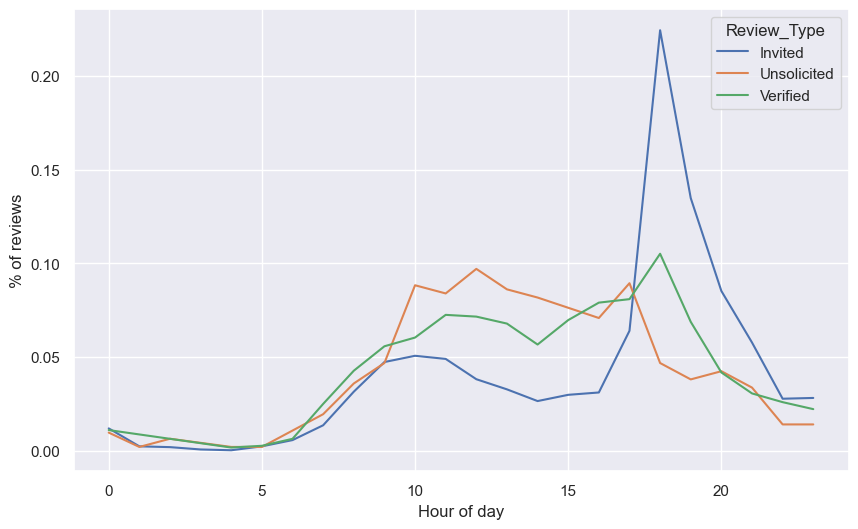

In [13]:
#Use data to do sentiment analysis - add labels for each word

#Get variable names
print(df_trustpilot.columns)

#Take a look at the text of the reviews
print(df_trustpilot['Review_Title'].head())
print(df_trustpilot['Review_Text'].head())

#Count Breakdowns
star_counts = df_trustpilot['Review_Stars'].value_counts().sort_values(ascending=False)
print(star_counts)

num_review_counts = df_trustpilot['Num_Of_Reviews'].value_counts().sort_values(ascending=False)
print(num_review_counts)

reviewtype_counts = df_trustpilot['Review_Type'].value_counts().sort_values(ascending=False)
print(reviewtype_counts)

#Visualise when reviews were done during the day
sns.set_theme()
df_trustpilot['hour'] = df_trustpilot['Posted_DateTime'].dt.hour
hourly_counts = df_trustpilot.groupby(['Review_Type','hour']).size().reset_index(name='count')
hourly_counts['percent'] = hourly_counts.groupby(['Review_Type'])['count'].transform(lambda x: x / x.sum())
plt.figure(figsize=(10,6))
sns.lineplot(data=hourly_counts, x='hour', y='percent', hue='Review_Type')
plt.xlabel('Hour of day')
plt.ylabel('% of reviews')
plt.show()

### Looking into most commonly used words in the reviews

In [18]:
#Analysing the words in the reviews

#Define a pattern (rege) to extract words and remove symbols
pattern = r"([^A-Za-z\d#@]|'(?![A-Za-z\d#@]))"

#Clean the text, extract words for all reviews, remove blanks and stopwords like and/or etc
df_trustpilot_alt = df_trustpilot.assign(words = df_trustpilot['Review_Text'].str.lower().str.split())

review_words = df_trustpilot_alt.explode('words')
review_words['words'] = review_words['words'].str.replace(pattern, '')
review_words = review_words[~review_words['words'].isin(stopwords.words('english'))]
review_words = review_words[~review_words['words'].isin([' ','',None])]

#Most commonly used words
word_counts = review_words['words'].value_counts().sort_values(ascending=False)
type(word_counts)
print(word_counts[:20])


words
easy        1542
account     1183
interest     769
good         735
rate         628
bank         607
paragon      582
isa          491
open         436
rates        435
new          406
hodge        398
online       398
service      395
transfer     374
process      346
customer     323
account.     321
savings      317
set          314
Name: count, dtype: int64


### Sentiment Analysis word by word

In [25]:
#Sentiment analysis word by word (NB: trad way, using lexicons)

#Create sentiment intensity analyser object
sia = SentimentIntensityAnalyzer()

#Apply sentiment analysis to each review word
review_words['sentiment'] = review_words['words'].apply(lambda word: sia.polarity_scores(str(word))['compound'])
review_words_grpbystars = review_words.groupby('Review_Stars')['sentiment'].mean().reset_index()
review_words_grpbyreview = review_words.groupby('ReviewNum')['sentiment'].mean().reset_index()

#Print Sentiment Analysis Results
print(review_words_grpbystars)
print(review_words_grpbyreview)

   Review_Stars  sentiment
0             1  -0.001676
1             2   0.009130
2             3   0.024453
3             4   0.044363
4             5   0.073799
      ReviewNum  sentiment
0             1   0.069227
1             2   0.198367
2             3   0.094856
3             4   0.200825
4             5   0.100200
...         ...        ...
4391       4392  -0.007696
4392       4393   0.009371
4393       4394   0.003972
4394       4395   0.086700
4395       4396  -0.064635

[4396 rows x 2 columns]


### Sentiment Analysise Review by Review

In [26]:
#Sentiment analysis on each review (Vader can do this)

#Create function to apply sentiment score (to not throw errors when review text is empty)
def CalcSentim(x):
    try:
        return sia.polarity_scores(str(x))['compound']
    except:
        return np.nan

df_trustpilot['TitleAndReview_Sentiment'] = df_trustpilot['Review_TitleAndText'].apply(CalcSentim)
df_trustpilot['Review_Sentiment'] = df_trustpilot['Review_Text'].apply(CalcSentim)
df_trustpilot['Title_Sentiment'] = df_trustpilot['Review_Title'].apply(CalcSentim)

### Correlation of Vader Sentiment Scores vs TrustPilot review scores

In [33]:
df_trustpilot['Review_Stars'].isna().sum()

0

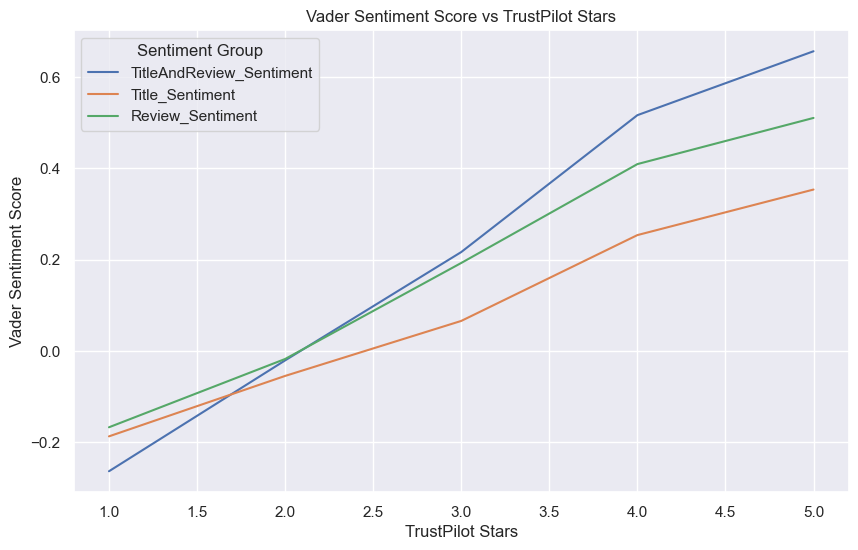

In [38]:
#Plot sentiment scores vs TrustPilot review scores
sns.set_theme()

SentVsScore = df_trustpilot[['Review_Stars','TitleAndReview_Sentiment','Title_Sentiment','Review_Sentiment']]
SentVsScore = SentVsScore.groupby(['Review_Stars']).mean().reset_index()
SentVsScore_trans = pd.melt(SentVsScore, id_vars=['Review_Stars'],var_name='Sentiment Group',value_name='Avg_Sentiments')
SentVsScore_trans

plt.figure(figsize=(10,6))
sns.lineplot(data=SentVsScore_trans, x='Review_Stars',y='Avg_Sentiments', hue='Sentiment Group').set(title='Vader Sentiment Score vs TrustPilot Stars')
plt.xlabel('TrustPilot Stars')
plt.ylabel('Vader Sentiment Score')
plt.show()

#Title and Review visually best? Although repetition in title and first line of text a concern?

### Export Reviews Data with Sentiment Scoring per Review

In [ ]:
df_trustpilot = df_trustpilot.drop(columns=['Review_Text'])
df_trustpilot.to_json('sentimentdata.json')
df_trustpilot.to_csv('sentimentdata.csv')